# Transformation Interpolations:  DES DR2 <--> Stetson UBVRI

_Douglas L. Tucker_

_2021.03.17_

## Initial Setup

In [1]:
import numpy as np
import pandas as pd

import os
import sys
import glob
import math
import datetime

from collections import OrderedDict as odict

from astropy.io import fits
from astropy.table import Table

import fitsio

from scipy import interpolate
from scipy.optimize import leastsq

import healpy as hp
import healpixTools

import extinction

import paramFile

import plotly
from plotly.offline import download_plotlyjs, plot, iplot
import plotly.graph_objs as go

import matplotlib.pyplot as plt

%matplotlib inline

## Input Parameters

In [55]:
# Stetson-->DES (toDES=True) or DES-->Stetson (toDES=False)...
toDES = True
#toDES = False


if toDES:
    # List of DES bands on which to run the transform fit...
    bandList = ['g_des', 'r_des', 'i_des', 'z_des', 'Y_des']
    # If Stetson-->DES, then the mag and color to fit against are Stetson...
    # Dictionary of corresponding bands from the other survey...
    matchBand_dict = {'g_des':'V', 'r_des':'R', 'i_des':'I', 'z_des':'I', 'Y_des':'I'}
    # Color to fit against...
    color_name_1_dict = {'g_des':'BV', 'r_des':'RI', 'i_des':'RI', 'z_des':'RI', 'Y_des':'RI'}
    # Name of color_name_1 as the label in the QA plots...
    colorLabel_1_dict = {'g_des':'$(B-V)$', 'r_des':'$(R-I)$', 'i_des':'$(R-I)$', 'z_des':'$(R-I)$', 'Y_des':'$(R-I)$'}

else:    
    # List of Stetson bands on which to run the transform fit...
    bandList = ['B', 'V', 'R', 'I']
    # If DES-->Stetson, then the mag and color to fit against are DES...
    # Dictionary of corresponding bands from the other survey...
    matchBand_dict = {'B':'g_des', 'V':'g_des', 'R':'r_des', 'I':'i_des'}
    # Color to fit against...
    color_name_1_dict = {'B':'gr_des', 'V':'gr_des', 'R':'ri_des', 'I':'ri_des'}
    # Name of color_name_1 as the label in the QA plots...
    colorLabel_1_dict = {'B':'$(g-r)_{des}$', 'V':'$(g-r)_{des}$', 'R':'$(r-i)_{des}$', 'I':'$(r-i)_{des}$'}


# Size of the binsize in color
color_binsize = 0.10

# Identify directory containing the DES/Stetson match file...
matchDir = './Stetson_UBVRI_data'

# Name of the DES/Stetson match file in matchDir
matchFile = 'match.Stetson_UBVRI.Y6A2_COADD.fits'


# Base name of fit results output file...
if toDES:
    resultsFileBaseName = 'transInterp.stetson_to_des'
else:
    resultsFileBaseName = 'transInterp.des_to_stetson'

# Base name of QA plot output files...
if toDES:
    qaFileBaseName = 'qaPlot.stetson_to_des.interp'
else:
    qaFileBaseName = 'qaPlot.des_to_stetson.interp'

# Verbosity level (0, 1, 2, 3, ...)
verbose = 2

## Define Some Modules

In [36]:
# From Zeljko Ivezic:
# Robust estimate of standard deviation: 0.741*(q75-q25)
#  sigmaG = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))
# Uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
#  sigGbin[i] = np.sqrt(np.pi/2)*sigmaG/np.sqrt(nPts[i])

def robustStdDev(data):
    try:
        sd = 0.741*(np.percentile(data,75)-np.percentile(data,25))
    except:
        sd = -9999.
    return sd

def uncMedian(data, npts):
    sd = robustStdDev(data)
    try:
        uncMedian = np.sqrt(np.pi/2)*sd/np.sqrt(npts)
    except:
        uncMedian = -9999.
    return uncMedian

In [37]:
##################################

def interp1ColorQAPlots1(df, df1, color_name_1, color1_min, color1_max, 
                         title, dmagLabel, outputFileName, verbose):

        
    # Create linear interpolation of the median dmag vs. color bin calculated above...
    response = interpolate.interp1d(df1.index.values.astype(float), df1.bin_median.values, \
                                bounds_error=False, fill_value=0., kind='linear')    

    # Calculate and apply the offset for the individual stars in df, 
    #  based on the linear interpolation calculated above...
    df['offset'] = response(df[color_name_1].values)    
    df['res'] = df['dmag'] - df['offset']    
    if verbose>1:
        print 
        print df[[color_name_1, 'offset', 'res']].head()
        print 

    # Calculate the 'robust' RMS of the residuals....
    rms = robustStdDev(df['res'].values)


    # Identify range to plot in the dmag (Y-axis) direction...
    dmag_desc = df['dmag'].describe(percentiles=[0.001, 0.999])
    if verbose>1:
        print dmag_desc
    dmag_min = math.floor(10*dmag_desc['0.1%'])/10.
    dmag_max = math.ceil(10*dmag_desc['99.9%'])/10.

    dmag_mask = (df['dmag'] >= dmag_min) & (df['dmag'] <= dmag_max)
    df_dmag_mask = df[dmag_mask]
    

    # Identify range to plot in the residuals (Y-axis) direction...
    res_desc = df['res'].describe(percentiles=[0.01, 0.99])
    if verbose>1:
        print 
        print res_desc
        print 
    #res_min = math.floor(10*dmag_desc['1%'])/10.
    #res_max = math.ceil(10*dmag_desc['99%'])/10.
    # What the heck; let's just set this to -0.10 mag --> +0.10 mag...
    res_min = -0.10
    res_max = +0.10


    # For 2d binning below, we mask df for just those stars within 
    #  the res_min, res_max range...
    res_mask = (df['res'] >= res_min) & (df['res'] <= res_max)
    df_res_mask = df[res_mask]
    
    
    # Prepare QA plots...
    #fig = plt.figure(figsize=(40,20))
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.3)
    
    # Modify matplotlib font...
    #font = {'family' : 'normal',
    #        'weight' : 'bold',
    #       'size'   : 22}
    #matplotlib.rc('font', **font)    
    plt.rcParams.update({'font.size': 24})

    
    ## Include a supertitle to the matplotlob figure...
    #fig.suptitle('This is the superTitle')

    
    # Plot 1:  Descriptive text...
    plt.subplot(221)
    plot1Text = """%s \n\n\n\n%s vs. %s\n\n[rms: %.3f] \n\n[%.1f < %s < %.1f]""" % \
                    (title, dmagLabel, colorLabel_1, rms, color1_min, colorLabel_1, color1_max)
    plt.text(0.1,0.00,plot1Text)
    plt.axis('off')

    
    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    plt.subplot(222)
    hb=plt.hexbin(df_dmag_mask[color_name_1].values, df_dmag_mask['dmag'].values, \
                      gridsize=100, bins='log', cmap='inferno')
    ax=plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel_1)
    plt.ylabel(dmagLabel)
    cb = fig.colorbar(hb)
    #cb.set_label('Number')
    cb.set_label('log10(N)')
    plt.grid(color='white')
    plt.grid(True)
    # Overplot the binned values calculated above:
    plt.errorbar(df1.index.values.astype(float), df1.bin_median.values, yerr=df1.bin_unc.values, fmt='o')

    
    # Plot 3:  1d histogram of residuals...
    plt.subplot(223) 
    plt.hist(df_res_mask.loc[:,'res'],bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.xlim([res_min, res_max])
    plt.grid(True)
    plt.grid(color='black')

    
    # Plot 4:  2d hexbin histogram of residuals vs. color1...
    plt.subplot(224) 
    hb=plt.hexbin(df_res_mask.loc[:, color_name_1].values, df_res_mask.loc[:,'res'].values, \
                  gridsize=100, bins='log', cmap='inferno')
    ax=plt.axis([color1_min, color1_max, res_min, res_max])
    plt.xlabel(colorLabel_1)
    plt.ylabel('Residuals')
    cb = fig.colorbar(hb)
    #cb.set_label('Number')
    cb.set_label('log10(N)')
    plt.grid(color='white')
    plt.grid(True)
    
    
    # Plot...
    plt.tight_layout()
    

    # Save QA plots to file...
    plt.savefig(outputFileName)    
    

    return 0


##################################

## Read in Matched Catalog

In [5]:
matchFile = os.path.join(matchDir,matchFile)
print matchFile

./Stetson_UBVRI_data/match.Stetson_UBVRI.Y6A2_COADD.fits


In [6]:
# Check to make sure matchFile exists...
if os.path.isfile(matchFile)==False:
    print """ERROR:  matchFile %s does not exist...""" % (matchFile)
if verbose > 0:
    print 'matchFile: ', matchFile


matchFile:  ./Stetson_UBVRI_data/match.Stetson_UBVRI.Y6A2_COADD.fits


In [7]:
tab = Table.read(matchFile, format='fits')
tab

name_pho,mag_U,sigma_U,N_U,n_U,mag_B,sigma_B,N_B,n_B,mag_V,sigma_V,N_V,n_V,mag_R,sigma_R,N_R,n_R,mag_I,sigma_I,N_I,n_I,vary,raDeg,decDeg,raHMS,decDMS,dracosd,ddec,dX,dY,name_pos,COADD_OBJECT_ID,RA,DEC,ALPHAWIN_J2000,DELTAWIN_J2000,PFW_ATTEMPT_ID,OBJECT_NUMBER,PARENT_NUMBER,TILENAME,L,B,EBV_SFD98,HPIX_32,HPIX_64,HPIX_1024,HPIX_4096,HPIX_16384,KRON_RADIUS,A_IMAGE,B_IMAGE,THETA_J2000,ERRA_IMAGE,ERRB_IMAGE,ERRTHETA_IMAGE,XWIN_IMAGE,YWIN_IMAGE,MAG_DETMODEL_G,MAG_AUTO_G,MAG_APER_8_G,WAVG_MAG_PSF_G,MAGERR_DETMODEL_G,MAGERR_AUTO_G,MAGERR_APER_8_G,WAVG_MAGERR_PSF_G,FLUX_DETMODEL_G,FLUX_AUTO_G,WAVG_FLUX_PSF_G,FLUX_RADIUS_G,FLUX_APER_8_G,FLUXERR_DETMODEL_G,FLUXERR_AUTO_G,WAVG_FLUXERR_PSF_G,FLUXERR_APER_8_G,MU_EFF_MODEL_G,MU_MAX_G,MU_MAX_MODEL_G,MU_MEAN_MODEL_G,MU_THRESHOLD_G,SPREADERR_MODEL_G,SPREAD_MODEL_G,CLASS_STAR_G,NITER_MODEL_G,WAVG_SPREADERR_MODEL_G,WAVG_SPREAD_MODEL_G,FLAGS_G,IMAFLAGS_ISO_G,NEPOCHS_G,MOLY_NUMBER_G,MAG_DETMODEL_R,MAG_AUTO_R,MAG_APER_8_R,WAVG_MAG_PSF_R,MAGERR_DETMODEL_R,MAGERR_AUTO_R,MAGERR_APER_8_R,WAVG_MAGERR_PSF_R,FLUX_DETMODEL_R,FLUX_AUTO_R,WAVG_FLUX_PSF_R,FLUX_RADIUS_R,FLUX_APER_8_R,FLUXERR_DETMODEL_R,FLUXERR_AUTO_R,WAVG_FLUXERR_PSF_R,FLUXERR_APER_8_R,MU_EFF_MODEL_R,MU_MAX_R,MU_MAX_MODEL_R,MU_MEAN_MODEL_R,MU_THRESHOLD_R,SPREADERR_MODEL_R,SPREAD_MODEL_R,CLASS_STAR_R,NITER_MODEL_R,WAVG_SPREADERR_MODEL_R,WAVG_SPREAD_MODEL_R,FLAGS_R,IMAFLAGS_ISO_R,NEPOCHS_R,MOLY_NUMBER_R,MAG_DETMODEL_I,MAG_AUTO_I,MAG_APER_8_I,WAVG_MAG_PSF_I,MAGERR_DETMODEL_I,MAGERR_AUTO_I,MAGERR_APER_8_I,WAVG_MAGERR_PSF_I,FLUX_DETMODEL_I,FLUX_AUTO_I,WAVG_FLUX_PSF_I,FLUX_RADIUS_I,FLUX_APER_8_I,FLUXERR_DETMODEL_I,FLUXERR_AUTO_I,WAVG_FLUXERR_PSF_I,FLUXERR_APER_8_I,MU_EFF_MODEL_I,MU_MAX_I,MU_MAX_MODEL_I,MU_MEAN_MODEL_I,MU_THRESHOLD_I,SPREADERR_MODEL_I,SPREAD_MODEL_I,CLASS_STAR_I,NITER_MODEL_I,WAVG_SPREADERR_MODEL_I,WAVG_SPREAD_MODEL_I,FLAGS_I,IMAFLAGS_ISO_I,NEPOCHS_I,MOLY_NUMBER_I,MAG_DETMODEL_Z,MAG_AUTO_Z,MAG_APER_8_Z,WAVG_MAG_PSF_Z,MAGERR_DETMODEL_Z,MAGERR_AUTO_Z,MAGERR_APER_8_Z,WAVG_MAGERR_PSF_Z,FLUX_DETMODEL_Z,FLUX_AUTO_Z,WAVG_FLUX_PSF_Z,FLUX_RADIUS_Z,FLUX_APER_8_Z,FLUXERR_DETMODEL_Z,FLUXERR_AUTO_Z,WAVG_FLUXERR_PSF_Z,FLUXERR_APER_8_Z,MU_EFF_MODEL_Z,MU_MAX_Z,MU_MAX_MODEL_Z,MU_MEAN_MODEL_Z,MU_THRESHOLD_Z,SPREADERR_MODEL_Z,SPREAD_MODEL_Z,CLASS_STAR_Z,NITER_MODEL_Z,WAVG_SPREADERR_MODEL_Z,WAVG_SPREAD_MODEL_Z,FLAGS_Z,IMAFLAGS_ISO_Z,NEPOCHS_Z,MOLY_NUMBER_Z,MAG_DETMODEL_Y,MAG_AUTO_Y,MAG_APER_8_Y,WAVG_MAG_PSF_Y,MAGERR_DETMODEL_Y,MAGERR_AUTO_Y,MAGERR_APER_8_Y,WAVG_MAGERR_PSF_Y,FLUX_DETMODEL_Y,FLUX_AUTO_Y,WAVG_FLUX_PSF_Y,FLUX_RADIUS_Y,FLUX_APER_8_Y,FLUXERR_DETMODEL_Y,FLUXERR_AUTO_Y,WAVG_FLUXERR_PSF_Y,FLUXERR_APER_8_Y,MU_EFF_MODEL_Y,MU_MAX_Y,MU_MAX_MODEL_Y,MU_MEAN_MODEL_Y,MU_THRESHOLD_Y,SPREADERR_MODEL_Y,SPREAD_MODEL_Y,CLASS_STAR_Y,NITER_MODEL_Y,WAVG_SPREADERR_MODEL_Y,WAVG_SPREAD_MODEL_Y,FLAGS_Y,IMAFLAGS_ISO_Y,NEPOCHS_Y,MOLY_NUMBER_Y,Separation
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec
str12,float32,float32,int16,int16,float32,float32,int16,int16,float32,float32,int16,int16,float32,float32,int16,int16,float32,float32,int16,int16,float32,float64,float64,str11,str11,float32,float32,float32,float32,str12,int64,float64,float64,float64,float64,int64,int32,int32,str12,float32,float32,float64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int16,int32,int32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int16,int32,int32,int64,float32,floa

In [10]:
df = tab.to_pandas()
df

,name_pho,mag_U,sigma_U,N_U,n_U,mag_B,sigma_B,N_B,n_B,mag_V,...,SPREAD_MODEL_Y,CLASS_STAR_Y,NITER_MODEL_Y,WAVG_SPREADERR_MODEL_Y,WAVG_SPREAD_MODEL_Y,FLAGS_Y,IMAFLAGS_ISO_Y,NEPOCHS_Y,MOLY_NUMBER_Y,Separation
0,AB_Lep-S2,99.999001,9.9999,0,0,99.999001,9.9999,0,0,16.277000,...,0.000080,0.824420,31,0.000044,-0.000286,2,0,6,2852916500002808,0.046235
1,AB_Lep-S6,99.999001,9.9999,0,0,16.681000,0.0152,9,9,16.160000,...,0.000713,0.910380,36,0.000045,0.000031,0,0,5,2852916500002807,0.040961
2,AB_Lep-S8,99.999001,9.9999,0,0,99.999001,9.9999,0,0,16.108999,...,0.001047,0.975248,31,0.000044,0.000407,2,0,3,2852916500002807,0.073967
3,AM1-S1,99.999001,9.9999,0,0,18.752001,0.0039,19,27,17.983999,...,0.000182,0.956209,27,0.000106,-0.000195,2,0,8,2840886500001558,0.082735
4,AM1-S2,99.999001,9.9999,0,0,19.799999,0.0083,19,26,18.365000,...,-0.001730,0.980777,24,0.000063,-0.000237,0,0,6,2840886500001600,0.071885
5,AM1-S3,99.999001,9.9999,0,0,16.813000,0.0041,19,27,16.238001,...,0.000164,0.916683,36,0.000039,-0.000183,0,0,8,2840886500001558,0.064769
6,AM1-S4,99.999001,9.9999,0,0,17.575001,0.0097,19,27,16.677999,...,0.000083,0.902335,42,0.000046,-0.000332,0,0,7,2840886500001599,0.076186
7,AM1-S5,99.999001,9.9999,0,0,19.789000,0.0110,19,27,18.704000,...,-0.001764,0.977579,25,0.000145,-0.000496,0,0,6,2840886500001601,0.056641
8,AM1-S6,99.999001,9.9999,0,0,18.181000,0.0042,19,26,17.739000,...,0.000205,0.884834,35,0.000128,-0.000257,0,0,7,2840886500001602,0.067364
9,AM1-S7,99.999001,9.9999,0,0,18.319000,0.0033,19,27,17.000999,...,0.001027,0.956051,48,0.000035,-0.000106,2,0,7,2840886500001595,0.094598


In [11]:
# Rename columns...
df.rename(columns={'RA':'RA_des',
                   'DEC':'DEC_des',
                   'raDeg':'RA_stetson',
                   'decDeg':'DEC_stetson',
                   'WAVG_MAG_PSF_G':'g_des',
                   'WAVG_MAG_PSF_R':'r_des',
                   'WAVG_MAG_PSF_I':'i_des',
                   'WAVG_MAG_PSF_Z':'z_des',
                   'WAVG_MAG_PSF_Y':'Y_des',
                   'WAVG_MAGERR_PSF_G':'g_err_des',
                   'WAVG_MAGERR_PSF_R':'r_err_des',
                   'WAVG_MAGERR_PSF_I':'i_err_des',
                   'WAVG_MAGERR_PSF_Z':'z_err_des',
                   'WAVG_MAGERR_PSF_Y':'Y_err_des',
                   'B':'B_LAT',
                   'G':'G_LONG',
                   'mag_U':'U',
                   'mag_B':'B',
                   'mag_V':'V',
                   'mag_R':'R',
                   'mag_I':'I',
                   'sigma_U':'U_err',
                   'sigma_B':'B_err',
                   'sigma_V':'V_err',
                   'sigma_R':'R_err',
                   'sigma_I':'I_err',
                  },inplace=True)

df.head(5)

,name_pho,U,U_err,N_U,n_U,B,B_err,N_B,n_B,V,...,SPREAD_MODEL_Y,CLASS_STAR_Y,NITER_MODEL_Y,WAVG_SPREADERR_MODEL_Y,WAVG_SPREAD_MODEL_Y,FLAGS_Y,IMAFLAGS_ISO_Y,NEPOCHS_Y,MOLY_NUMBER_Y,Separation
0,AB_Lep-S2,99.999001,9.9999,0,0,99.999001,9.9999,0,0,16.277000,...,0.000080,0.824420,31,0.000044,-0.000286,2,0,6,2852916500002808,0.046235
1,AB_Lep-S6,99.999001,9.9999,0,0,16.681000,0.0152,9,9,16.160000,...,0.000713,0.910380,36,0.000045,0.000031,0,0,5,2852916500002807,0.040961
2,AB_Lep-S8,99.999001,9.9999,0,0,99.999001,9.9999,0,0,16.108999,...,0.001047,0.975248,31,0.000044,0.000407,2,0,3,2852916500002807,0.073967
3,AM1-S1,99.999001,9.9999,0,0,18.752001,0.0039,19,27,17.983999,...,0.000182,0.956209,27,0.000106,-0.000195,2,0,8,2840886500001558,0.082735
4,AM1-S2,99.999001,9.9999,0,0,19.799999,0.0083,19,26,18.365000,...,-0.001730,0.980777,24,0.000063,-0.000237,0,0,6,2840886500001600,0.071885


## Add Columns to Matched Catalog Data Frame

In [12]:
# Add color columns...
df.loc[:,'gr_des'] = df.loc[:,'g_des'] - df.loc[:,'r_des']
df.loc[:,'ri_des'] = df.loc[:,'r_des'] - df.loc[:,'i_des']
df.loc[:,'iz_des'] = df.loc[:,'i_des'] - df.loc[:,'z_des']
df.loc[:,'zY_des'] = df.loc[:,'z_des'] - df.loc[:,'Y_des']
df.loc[:,'gi_des'] = df.loc[:,'g_des'] - df.loc[:,'i_des']

df.loc[:,'UB'] = df.loc[:,'U'] - df.loc[:,'V']
df.loc[:,'BV'] = df.loc[:,'B'] - df.loc[:,'V']
df.loc[:,'VR'] = df.loc[:,'V'] - df.loc[:,'R']
df.loc[:,'RI'] = df.loc[:,'R'] - df.loc[:,'I']

In [13]:
# Insert dmag column...
df.loc[:,'dmag'] = -9999.

## Create Initial Mask

In [23]:
mask1 = df["N_B"] >= 5
mask2 = df["N_V"] >= 5
mask3 = df["N_R"] >= 5
mask4 = df["N_I"] >= 5
mask5 = df["B_err"] <= 0.02
mask6 = df["V_err"] <= 0.02
mask7 = df["R_err"] <= 0.02
mask8 = df["I_err"] <= 0.02
mask_stetson = mask1 & mask2 & mask3 & mask4 & mask5 & mask6 & mask7 & mask8

mask1 = df["g_des"] > 0.
mask2 = df["r_des"] > 0.
mask3 = df["i_des"] > 0.
mask4 = df["z_des"] > 0.
mask5 = df["Y_des"] > 0.
mask6 = df["g_err_des"] <= 0.02
mask7 = df["r_err_des"] <= 0.02
mask8 = df["i_err_des"] <= 0.02
mask9 = df["z_err_des"] <= 0.02
mask10 = df["Y_err_des"] <= 0.02
mask_des = mask1 & mask2 & mask3 & mask4 & mask5 & mask6 & mask7 & mask8 & mask9 & mask10

mask = mask_stetson & mask_des

## Make Backup Copies of Initial Mask and Original Data Frame

In [24]:
# Make a backup copy of original df...
df_orig = df.copy()

# Make a backup copy of original mask...
mask_orig = mask.copy()

In [49]:
#df.describe()
band = 'B'
magName = band
magName_match = matchBand_dict[band]
color_name_1 = color_name_1_dict[band]
colorLabel_1 = colorLabel_1_dict[band]
print magName_match
print color_name_1
print colorLabel_1

g_des
gr_des
$(g-r)_{des}$


## Run Fit in Each Filter Band




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
g_des
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

g_des
V
BV
$(B-V)$
g_des V BV $(B-V)$

count     7074.000000
mean         0.960870
std          0.372492
min         -0.150000
0.01%       -0.148586
50%          0.922000
99.99%       2.108440
max          2.153000
Name: BV, dtype: float64
-0.2 2.2

[-0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2
  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3]
[-0.15 -0.05  0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95
  1.05  1.15  1.25  1.35  1.45  1.55  1.65  1.75  1.85  1.95  2.05  2.15
  2.25]

         BV bin_interval bin_label
1  0.521000   (0.5, 0.6]      0.55
3  0.768002   (0.7, 0.8]      0.75
4  1.434999   (1.4, 1.5]      1.45
5  0.574999   (0.5, 0.6]      0.55
6  0.897001   (0.8, 0.9]      0.85


           bin_interval  bin_num  bin_mean  bin_stddev  bin_stderr  \
bin_label       

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des17a/lib/python2.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning:

invalid value encountered in sqrt






# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
r_des
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

r_des
R
RI
$(R-I)$
r_des R RI $(R-I)$

count     7074.000000
mean         0.568273
std          0.267477
min         -0.094999
0.01%       -0.094292
50%          0.507000
99.99%       1.867805
max          1.877000
Name: RI, dtype: float64
-0.1 1.9

[-0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9]
[-0.05  0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.05
  1.15  1.25  1.35  1.45  1.55  1.65  1.75  1.85]

         RI bin_interval bin_label
1  0.309000   (0.3, 0.4]      0.35
3  0.445000   (0.4, 0.5]      0.45
4  0.997000     (0.9, 1]      0.95
5  0.348000   (0.3, 0.4]      0.35
6  0.425001   (0.4, 0.5]      0.45


          bin_interval  bin_num  bin_mean  bin_stddev  bin_stderr  bin_median  \
bin_label                                                    




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Y_des
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Y_des
I
RI
$(R-I)$
Y_des I RI $(R-I)$

count     7074.000000
mean         0.568273
std          0.267477
min         -0.094999
0.01%       -0.094292
50%          0.507000
99.99%       1.867805
max          1.877000
Name: RI, dtype: float64
-0.1 1.9

[-0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9]
[-0.05  0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.05
  1.15  1.25  1.35  1.45  1.55  1.65  1.75  1.85]

         RI bin_interval bin_label
1  0.309000   (0.3, 0.4]      0.35
3  0.445000   (0.4, 0.5]      0.45
4  0.997000     (0.9, 1]      0.95
5  0.348000   (0.3, 0.4]      0.35
6  0.425001   (0.4, 0.5]      0.45


          bin_interval  bin_num  bin_mean  bin_stddev  bin_stderr  bin_median  \
bin_label                                                    

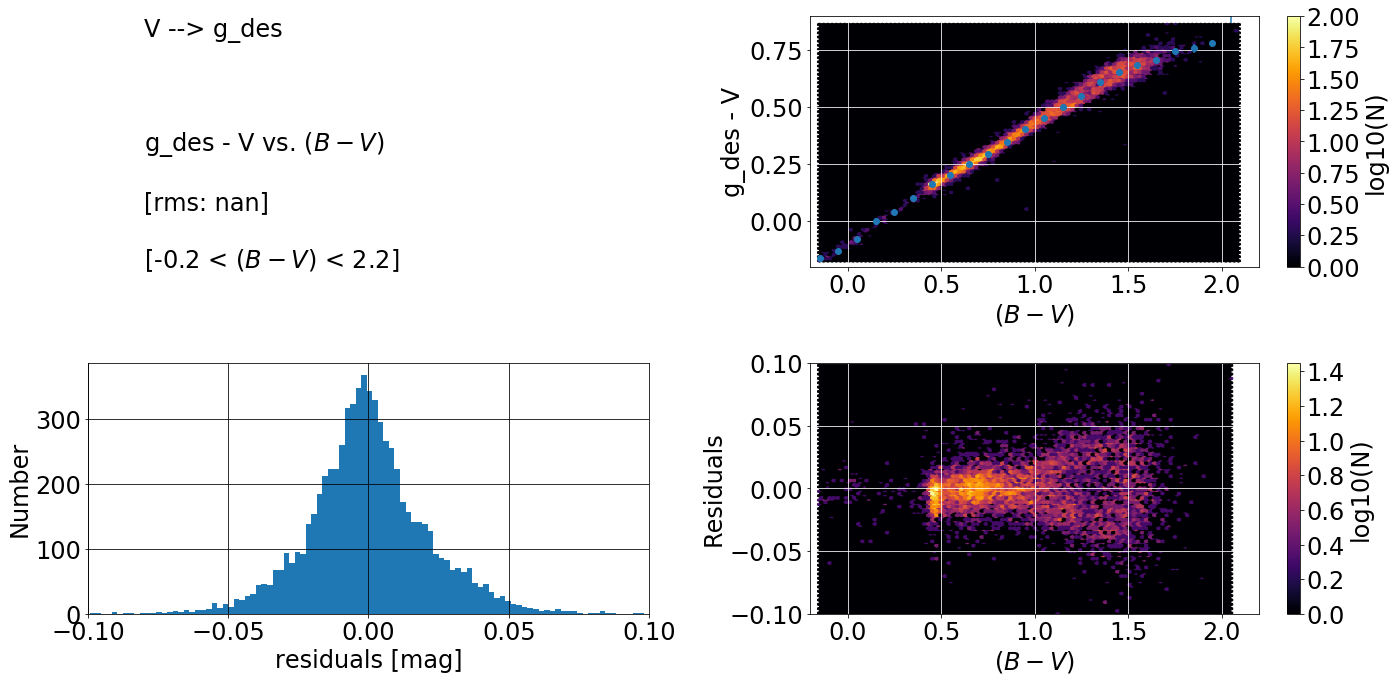

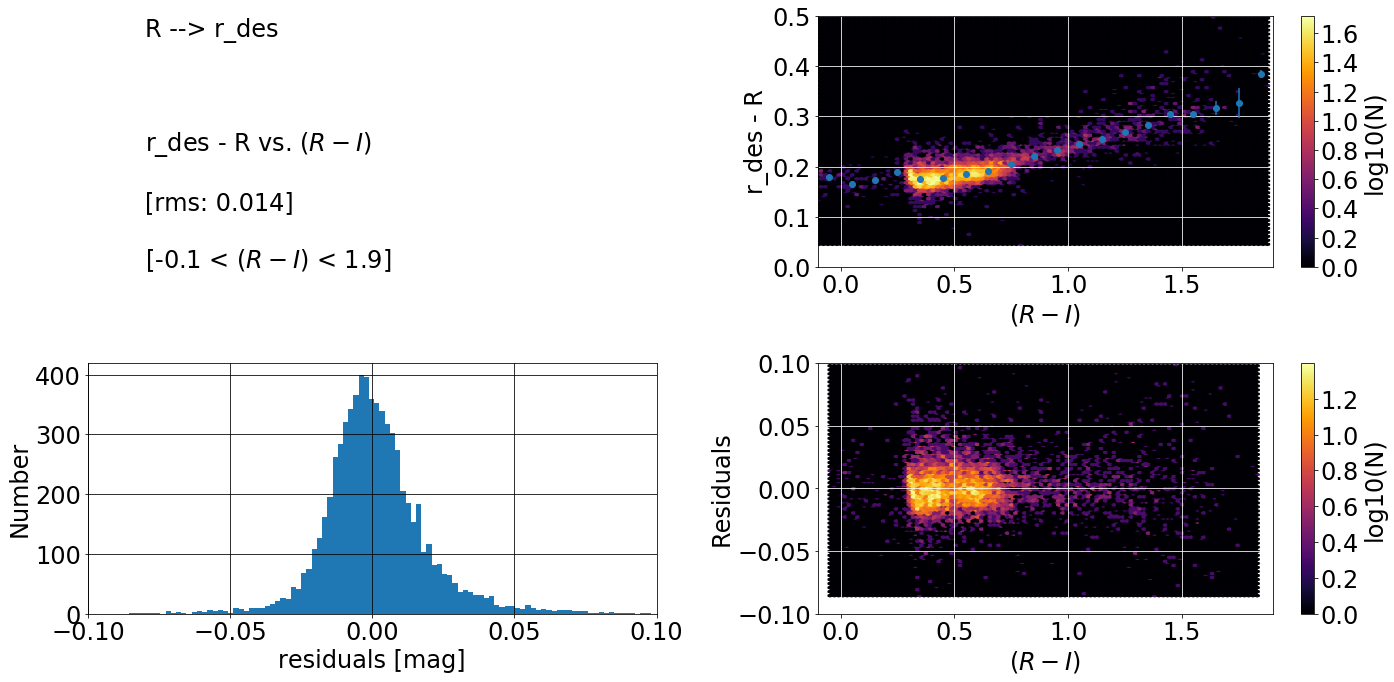

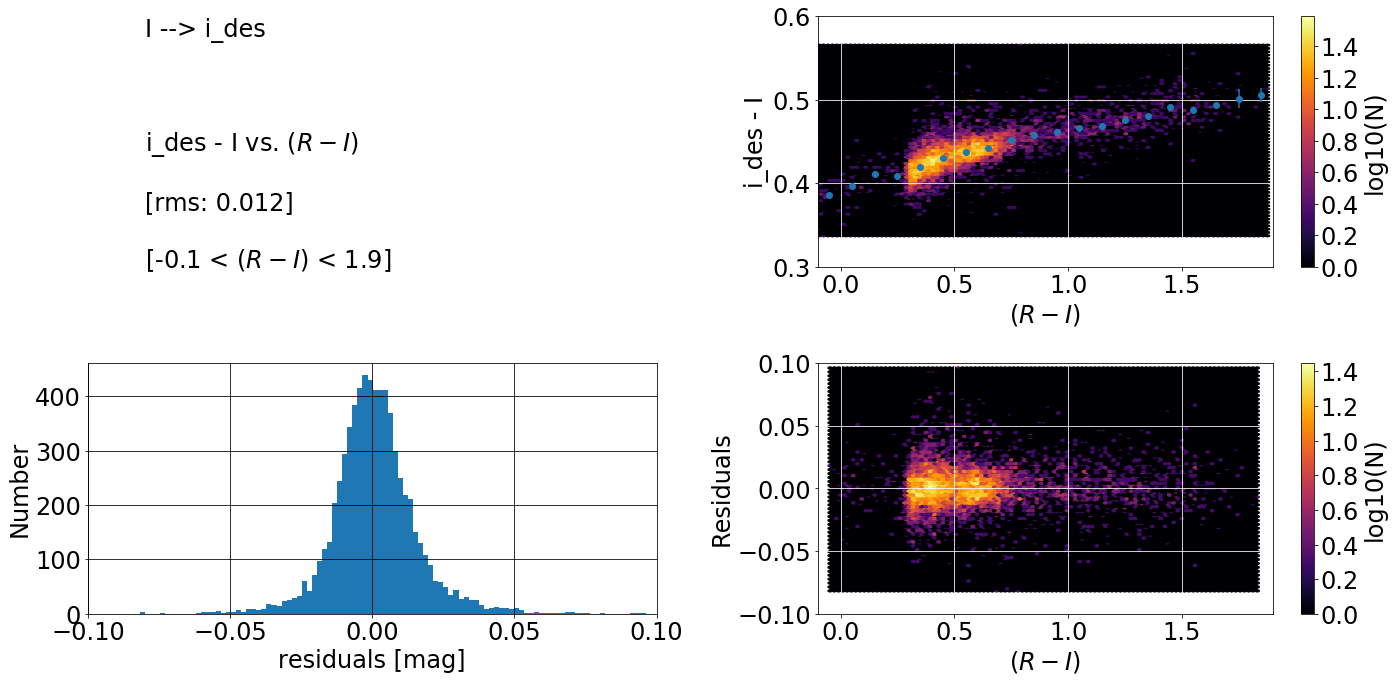

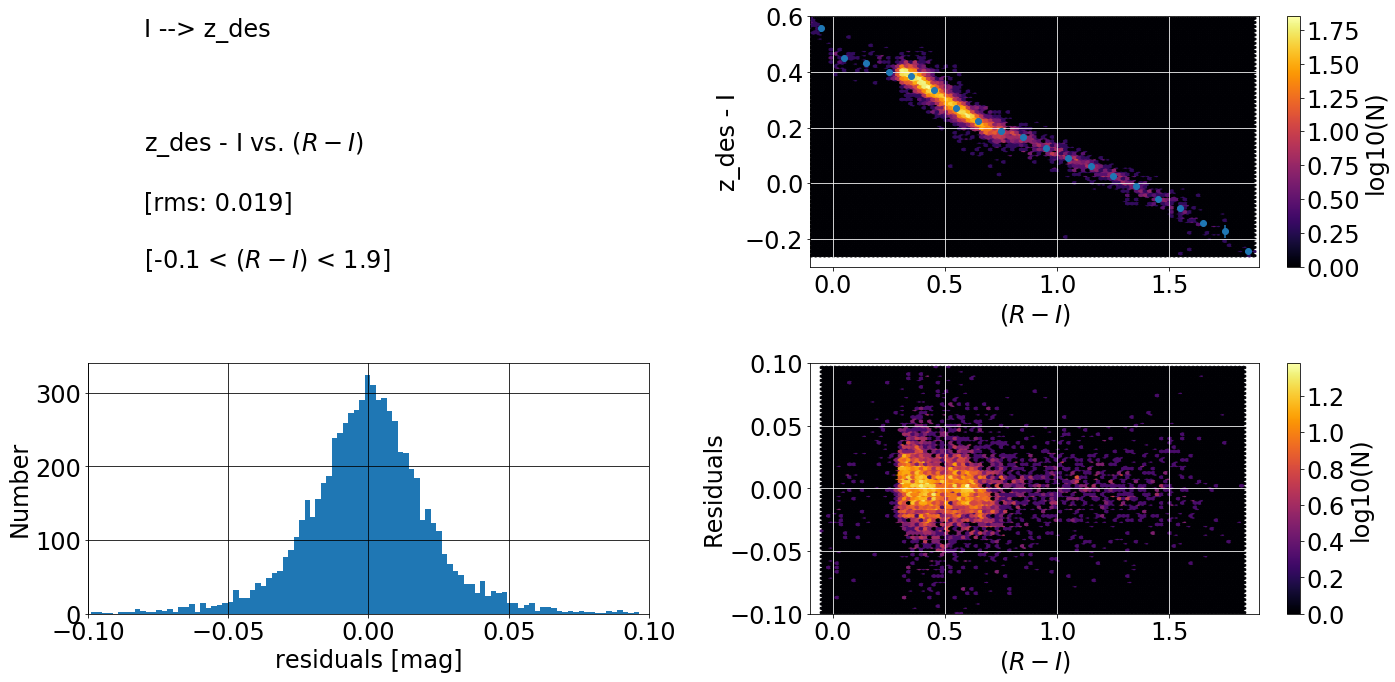

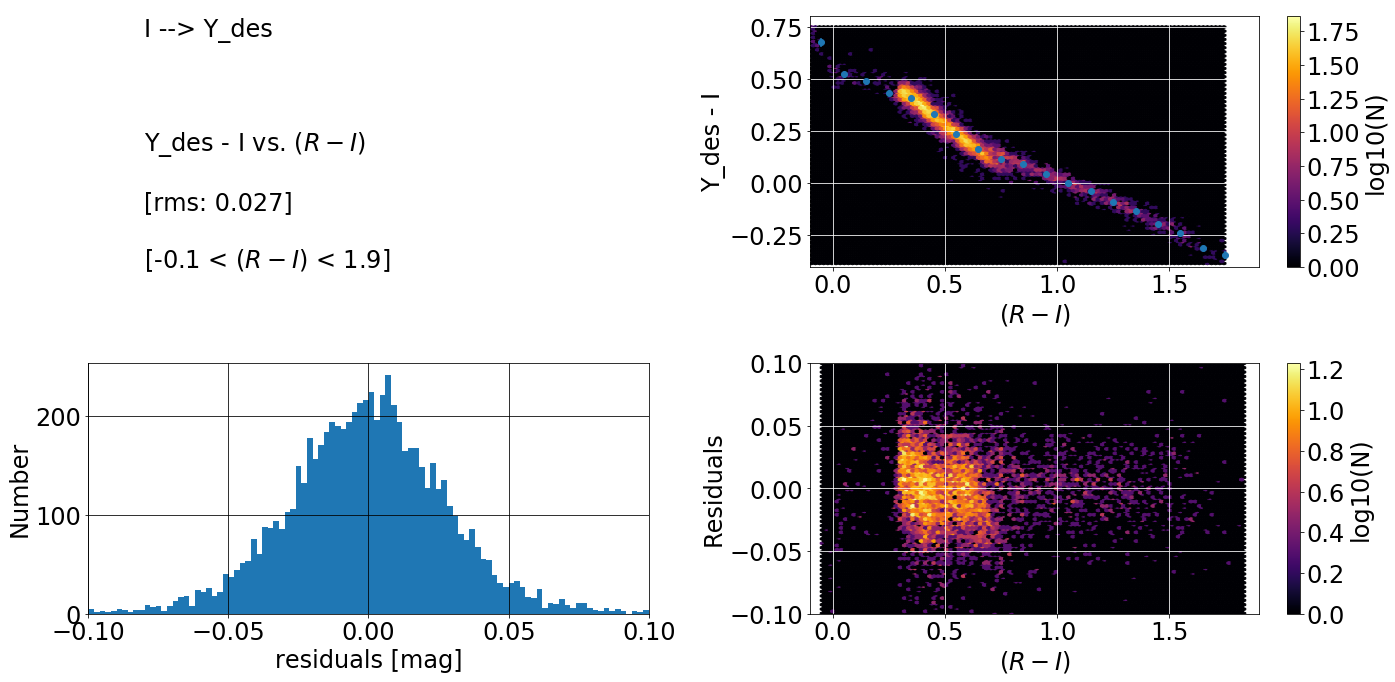

In [56]:
for band in bandList:
    
    print 
    print 
    print 
    print "# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # "
    print band
    print "# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # "
    print 
    
    magName = band
    magName_match = matchBand_dict[band]
    color_name_1 = color_name_1_dict[band]
    colorLabel_1 = colorLabel_1_dict[band]

    
    # Grab the original version of df from the backup copy...
    df = df_orig.copy()

    # Grab the original version of mask from the backup copy...
    mask = mask_orig.copy()

    # Update dmag column for {$band}_des - {$band}_ps1...
    df.loc[:,'dmag'] = df.loc[:,magName] - df.loc[:,magName_match]

    # Update mask...
    mask1 = abs(df['dmag']) <= 10.
    mask2 = ( ( df[color_name_1] > -3. ) & ( df[color_name_1] < 6.0 ) )
    mask = mask & mask1 & mask2

    # make a copy of original df, overwriting the old one...
    df = df[mask].copy()

    # Identify dmag and color1 series...
    dmag =  df.loc[:,'dmag']
    color1 = df.loc[:,color_name_1]


    # Calculate the color range to bin and the number of bins, 
    #  based on the 0.01%-99.99% color range...
    color1_desc = df[color_name_1].describe(percentiles=[0.0001, 0.9999])
    color1_min = math.floor(10*color1_desc['0.01%'])/10.
    color1_max = math.ceil(10*color1_desc['99.99%'])/10.
    if verbose>1:
        print 
        print color1_desc
        print color1_min, color1_max 
        print 
    binsize = color_binsize
    ranges = np.arange(color1_min,color1_max+binsize,binsize)
    # Label the bins by their mid-point...
    labels = np.arange(color1_min,color1_max,binsize) + 0.5*binsize
    
    #nbins = int((color1_max-color1_min)/binsize)+1
    #ranges = np.linspace(color1_min, color1_max, nbins+1)
    ## Label the bins by their mid-point...
    #labels = np.linspace(color1_min, color1_max-binsize, nbins) + 0.5*binsize

    #nbins = math.floor((color1_max-color1_min)/binsize) + 1
    #ranges = np.linspace(color1_min, color1_max, nbins)
    ## Label the bins by their mid-point...
    #labels = np.linspace(color1_min, color1_max-binsize, nbins-1) + 0.5*binsize
    
    if verbose:
        print ranges
        print labels
    
    # Bin the data, adding "bin_interval" and "bin_label' to the df dataframe...
    df['bin_interval'] = pd.cut(df[color_name_1], bins=ranges, precision=0)
    df['bin_label'] = pd.cut(df[color_name_1], bins=ranges, labels=labels)
    if verbose>1:
        print 
        print df[[color_name_1,'bin_interval','bin_label']].head()
        print 

    # Perform pandas grouping/aggregating functions on sigma-clipped Data Frame...
    df_grp = df.groupby(['bin_label'])
    bin_interval = df_grp['bin_interval'].first()
    dmag_num = df_grp['dmag'].count()
    dmag_mean = df_grp['dmag'].mean()
    dmag_sd = df_grp['dmag'].std()
    dmag_err = dmag_sd/np.sqrt(dmag_num-1)
    dmag_median = df_grp['dmag'].median()
    dmag_rsd = df_grp['dmag'].apply(robustStdDev)
    dmag_unc = np.sqrt(np.pi/2)*dmag_rsd/np.sqrt(dmag_num)

    # Rename some of the pandas series...
    dmag_num.name    = 'bin_num'
    dmag_mean.name   = 'bin_mean'
    dmag_sd.name     = 'bin_stddev'
    dmag_err.name    = 'bin_stderr'
    dmag_median.name = 'bin_median'
    dmag_rsd.name    = 'bin_rstddev'
    dmag_unc.name    = 'bin_unc'
    
    # Create new data frame containing all the relevant aggregate quantities...
    df1 = pd.concat( [bin_interval, dmag_num, \
                      dmag_mean, dmag_sd, dmag_err, \
                      dmag_median, dmag_rsd, dmag_unc, ], \
                    join='outer', axis=1 )
    
    if verbose>1:
        print 
        print df1
        print 
    
    
    # Create results output file...
    resultsFile = """%s.%s_%s.csv""" % (resultsFileBaseName, band, color_name_1)
    df1.to_csv(resultsFile)
    if verbose>1:
        print """Writing binned values to %s""" % (resultsFile)

    
    # Create name for QA plot output file...
    outputFileName = """qaPlot_%s.%s_%s_%s.png""" % (resultsFileBaseName, magName, magName_match, color_name_1)

    # Create title and labels for use in QA plots...
    title = """%s --> %s""" % (magName_match, magName)
    dmagLabel = """%s - %s""" % (magName, magName_match)

    # Create QA plots...
    status = interp1ColorQAPlots1(df, df1, color_name_1, color1_min, color1_max, 
                                     title, dmagLabel, outputFileName, verbose)
    
    